## Ejemplo predicción de precios.

La base de datos se puede encontrar en:<p>
https://www.kaggle.com/harlfoxem/housesalesprediction/data<p>
Predicción del precio de casas en King County, USA.<p>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

Veo la correlación entre la variable que quiero predecir (precio) y el resto:

In [44]:
df = pd.read_csv('data/kc_house_data.csv').set_index('id').drop('date', axis = 1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


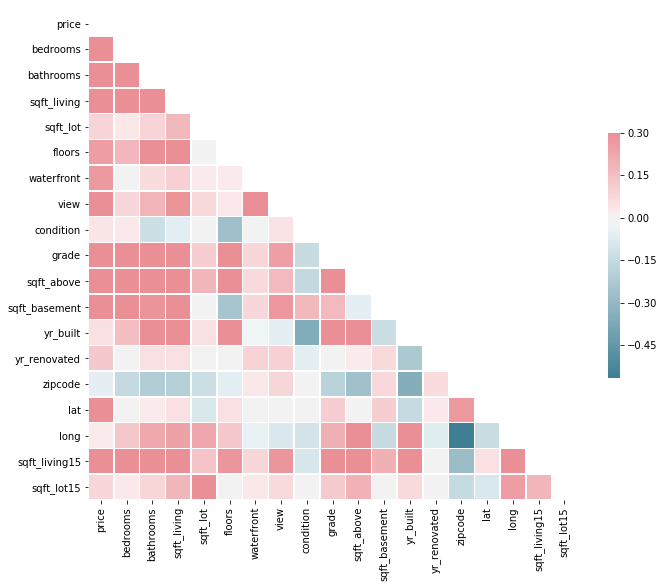

In [45]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Realizo un tratamiento de datos, transformo en variables categóricas (zipcode, grade, waterfront y condition) y posteriormente genero variables dummy. Elimino (id, date y long)

In [36]:
data = raw_data
data["zipcode"] = data["zipcode"].astype('category')
data["grade"] = data["grade"].astype('category')
data["waterfront"] = data["waterfront"].astype('category')
data["condition"] = data["condition"].astype('category')
data.drop(["id", "date", "long"], axis=1, inplace = True)
data = pd.get_dummies(data)

Primero divido la muestra en entrenamiento, validación y test con proporcion (60/20/20) <p>
Estandarizo todas las variables según la distribución de la muestra de entrenamiento dado que voy a aplicar regularización.

In [51]:
train, val, test = np.split(data.sample(frac=1, random_state=1),
                            [int(.6*len(data)), int(.8*len(data))])
X_train = train.iloc[:, 1:103]
X_val = val.iloc[:, 1:103]
X_test = test.iloc[:, 1:103]
y_train = train["price"]
y_val = val["price"]
y_test = test["price"]

Calculo distintos modelos en función de el parámetro de regularización y la complejidad de la hipótesis <p>
En scikit-learn es $\alpha=\dfrac{1}{C}$ y el grado del polinomio lo tomo de la función PolynomialFeatures ($d$). <p>
Calculo la raiz del error cuadrático medio para los tres data sets.

In [55]:
list_C = list([0.1, 0.0001,0.00000001,  
               0.000000001, 0.000000005])
list_d = [1, 2]; count = 0
mse_train = np.zeros(len(list_C)*len(list_d))
mse_val = np.zeros(len(list_C)*len(list_d))
mse_test = np.zeros(len(list_C)*len(list_d))
degree = np.zeros(len(list_C)*len(list_d))
param_C = np.zeros(len(list_C)*len(list_d))
R_test = np.zeros(len(list_C)*len(list_d))
for d in list_d:
    MapF = PolynomialFeatures(degree=d)
    for C in list_C:
        reg = Ridge(alpha = 1/C, normalize = True)
        reg.fit(MapF.fit_transform(X_train), y_train)
        mse_train[count] = np.sqrt(mean_squared_error(y_train,
                            reg.predict(MapF.fit_transform(X_train))))
        mse_val[count] = np.sqrt(mean_squared_error(y_val,
                          reg.predict(MapF.fit_transform(X_val))))
        mse_test[count] = np.sqrt(mean_squared_error(y_test, 
                           reg.predict(MapF.fit_transform(X_test))))
        R_test[count] = reg.score(MapF.fit_transform(X_test), y_test)
        degree[count] = d
        param_C[count]  = C
        count = count + 1

$\text{Observo alguno modelos y la raiz de su error cuadratico medio (RMSE).} \\
 \sqrt{J_\text{train}(\theta)} \text{ = Train RMSE} \\
 \sqrt{J_\text{val}(\theta)} \text{  = Validation RMSE} \\
 \sqrt{J_\text{test}(\theta)} \text{ = Test RMSE}$

In [56]:
matrix = np.matrix(np.c_[degree, param_C, np.round_(mse_train, 3), 
                         np.round_(mse_val, 3), np.round_(mse_test, 3), 
                         np.round_(R_test, 3)])
models = pd.DataFrame(data = matrix, columns = 
             ['d', 'parameter C', 'Train RMSE', 
              'Val RMSE', 'Test RMSE', 'R^2 Test'])
models.head(n=7)

,d,parameter C,Train RMSE,Val RMSE,Test RMSE,R^2 Test
0,1.0,1.000000e-01,296318.703,259268.546,298887.352,0.376
1,1.0,1.000000e-04,373991.357,332802.103,378265.116,0.001
2,1.0,1.000000e-08,374111.223,332916.853,378387.517,-0.000
3,1.0,1.000000e-09,374111.234,332916.863,378387.528,-0.000
4,1.0,5.000000e-09,374111.229,332916.858,378387.523,-0.000
5,2.0,1.000000e-01,154729.274,144827.712,162322.727,0.816
6,2.0,1.000000e-04,372741.416,331662.662,377011.421,0.007


Selecciono el modelo con menor raiz del error cuadrático medio sobre el conjunto de validación. La capacidad real de generalización vendrá dada por el error en el conjunto de test dado que es totalmente independiente al modelo elegido. Si evaluasemos este error con el conjunto de validación tenderíamos a sobreestimarlo dado que ha sido un parámetro a la hora de elegir el modelo. <p>
Modelo con menor RMSE en el conjunto de validación

In [57]:
best_index = models['Val RMSE'].idxmin()
models.iloc[best_index, :]

d                   2.000
parameter C         0.100
Train RMSE     154729.274
Val RMSE       144827.712
Test RMSE      162322.727
R^2 Test            0.816
Name: 5, dtype: float64

Mido la capacidad de generalización con $\sqrt{J_\text{test}(\theta)}$ y $R^2$ que es 0.878

In [58]:
MapF.fit_transform(X_train).shape

(12967, 5356)